# Banana Dataset

* 因為 object detection 沒有可以練習的小數據集，所以這邊 d2l 提供了一個 banana dataset 來供練習

## 下載和解壓縮

In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#@save
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')
d2l.download_extract('banana-detection')

* 現在，被放在當前目錄的上一層，架構為：  
  * data. 
    * bana-detection. 
      * bananas_train. 
        * images.   
          * 0.png  
          * 1.png. 
          * ...
          * 999.png
        * label.csv
      * bananas_val  
        * images. 
          * 0.png   
          * 1.png. 
          * ...
          * 99.png
        * label.csv

* 我們先快速看一下圖：

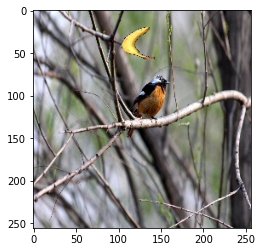

In [8]:
img = plt.imread("../data/banana-detection/bananas_train/images/0.png")
plt.imshow(img);

* 可以看到，一根香蕉出現在圖片的上面

* 來看一下 label 檔：

In [10]:
pd.read_csv("../data/banana-detection/bananas_train/label.csv")

,img_name,label,xmin,ymin,xmax,ymax
0,0.png,0,104,20,143,58
1,1.png,0,68,175,118,223
2,2.png,0,163,173,218,239
3,3.png,0,48,157,84,201
4,4.png,0,32,34,90,86
...,...,...,...,...,...,...
995,995.png,0,171,101,214,147
996,996.png,0,42,57,83,96
997,997.png,0,47,54,86,109
998,998.png,0,43,125,90,166


* 可以看到 第 0 張 image，他的 label 是 0，出現的位置(bounding box) 分別是 (104, 20, 143, 58)，就和圖上看到的一樣. 
* 這張 csv 檔可以擴充：  
  * 如果一張圖，有多個object (不管是相同or不同object)，例如 3 個 banana 和 1 個 orange，那就會重複 4 個 row，然後 label 前三個都是 0，最後一個是 1，然後 4 個座標會不同.   
* 但作為練習，他這邊只給了一個 object: banana，而且，每張圖只會出現一個 banana

## 讀取

* 我們寫一個 `read_data_banas` 函數，來讀取數據集. 

In [16]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签
    
    """
    data_dir = "../data/banana-detection"
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        cur_path = os.path.join(
            data_dir, 
            'bananas_train' if is_train else 'bananas_val', 
            'images', 
            f'{img_name}'
        )
        cur_img = torchvision.io.read_image(cur_path)
        images.append(cur_img)
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

* 然後是 torch 的 dataset

In [17]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + 
              str(len(self.features)) + 
              (f' training examples' if is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

* 例如這樣做：

In [19]:
train_dataset = BananasDataset(is_train = True)

read 1000 training examples


torch.float32


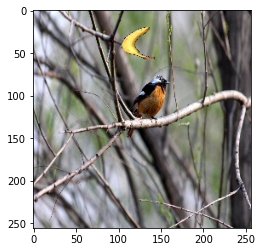

In [32]:
x, y = train_dataset.__getitem__(0)

print(x.dtype)
x_np_int = x.permute(1,2,0).detach().numpy().astype(int)
plt.imshow(x_np_int);

* 然後，y 長這樣：

In [33]:
print(y)

tensor([[0.0000, 0.4062, 0.0781, 0.5586, 0.2266]])


* 第一個 element 是他的 class label: 0, 剩下 4 個是 coordinates

* 最後是 torch 的 dataloader

In [31]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

* 來讀讀看吧：

In [34]:
# training parameters
batch_size, edge_size = 32, 256

# iterator
train_iter, _ = load_data_bananas(batch_size)

# 看一個 batch
batch = next(iter(train_iter))

print(batch[0].shape)
print(batch[1].shape)

read 1000 training examples
read 100 validation examples
torch.Size([32, 3, 256, 256])
torch.Size([32, 1, 5])


* 來讀 10 張含有 bounding box 的影像。
* 我們可以看到所有這些圖片中，香蕉的旋轉角度, 大小, 位置都有所不同。

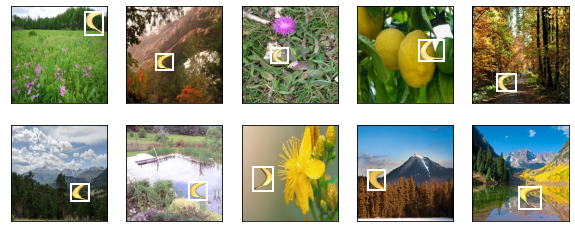

In [35]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])